### 1) Objective

a) Understand a sample dataset using vcd package and see how features are calibrated to check if they impact overall model performance in the context of using XGBoost

b) Prepare the dataset to create a sparse matrix structure from a simple Arthritis dataset within the vcd package to see how computed parameters can be created for handling categorical information, handling factor parameters.

c) Usage of eXtreme Gradient Boosting in R as an example


### 2) Load all required libraries / packages

In [2]:
install.packages("vcd")

also installing the dependency ‘lmtest’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
library(xgboost)
library(vcd)
library(Matrix)
library(data.table)

Loading required package: grid


### 3) Load the dataset

XGBoost can manage only numeric vectors.

We need to convert any categorical variables to numerical variables.
We are going to perform one hot encoding. In this VCD (Vignette dataset), we will see how to transform a dense data.frame (dense = few zeroes in the matrix) with categorical variables to a very sparse matrix (sparse = lots of zero in the matrix) of numeric features.

We load the "Arthritis" dataset in to memory and then wrap it with "data.table" package.

In [4]:
set.seed(1234)
data("Arthritis")
df <- data.table(Arthritis, keep.rownames = F)
head(df)

str(df)
# so 2 columns have factor type, one has ordinal type..


ID,Treatment,Sex,Age,Improved
57,Treated,Male,27,Some
46,Treated,Male,29,None
77,Treated,Male,30,None
17,Treated,Male,32,Marked
36,Treated,Male,46,Marked
23,Treated,Male,58,Marked


Classes ‘data.table’ and 'data.frame':	84 obs. of  5 variables:
 $ ID       : int  57 46 77 17 36 23 75 39 33 55 ...
 $ Treatment: Factor w/ 2 levels "Placebo","Treated": 2 2 2 2 2 2 2 2 2 2 ...
 $ Sex      : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 2 2 2 2 ...
 $ Age      : int  27 29 30 32 46 58 59 59 63 63 ...
 $ Improved : Ord.factor w/ 3 levels "None"<"Some"<..: 2 1 1 3 3 3 1 3 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


### 4) Data preparation

We will try to create new features from existing categorical variables.

Grouping per every 10 years for the age related categorical data.

a) We create a feature that create groups of age rounding the real age. We will have to transform it as factor variable so that the algorithm will treat these groups as independent values.
b) Then we will create another feature to random split on a threshold value - say age of 30. to determine who is old and who is young.

Now if we note here - these new features are highly correlated to the Age parameter as theyare simple transformations of this parameter.

Ideally for machine learning algorithms, it is not a good practice to use correlated features. It may sometimes make prediction less accurate, and most of the time demonstrate interpretation of the model almost impossible. For example: GLM, for instance, assumes that the features are uncorrelated. On other hand, fortunately, decision tree algorithms (including boosted trees) are very robust to these features. 

In [5]:
# Grouping per 10 years
head(df[,AgeDiscret := as.factor(round(Age/10,0))])
# Random split in two groups
head(df[,AgeCat:= as.factor(ifelse(Age > 30, "Old", "Young"))])
# Then performing data cleaning a bit, removing the ID field which is not needed
df[,ID:=NULL]
levels(df[,Treatment])

ID,Treatment,Sex,Age,Improved,AgeDiscret
57,Treated,Male,27,Some,3
46,Treated,Male,29,None,3
77,Treated,Male,30,None,3
17,Treated,Male,32,Marked,3
36,Treated,Male,46,Marked,5
23,Treated,Male,58,Marked,6


ID,Treatment,Sex,Age,Improved,AgeDiscret,AgeCat
57,Treated,Male,27,Some,3,Young
46,Treated,Male,29,None,3,Young
77,Treated,Male,30,None,3,Young
17,Treated,Male,32,Marked,3,Old
36,Treated,Male,46,Marked,5,Old
23,Treated,Male,58,Marked,6,Old


[1] "Placebo" "Treated"

#### One hot encoding - creation of Sparse Matrix
The categorical variables are transformed to dummy variables.

The purpose is to transform each value of each categorical feature in a binary feature {0, 1} to represent numerical matrix/vector form.

For example, the column Treatment will be replaced by two columns, Placebo, and Treated. Each of them will be binary. Therefore, an observation which has the value Placebo in column Treatment before the transformation will have after the transformation the value 1 in the new column Placebo and the value 0 in the new column Treated. The column Treatment will disappear during the one-hot encoding.

Column Improved is excluded because it will be our label column, the one we want to predict.

In [6]:
sparse_matrix <- sparse.model.matrix(Improved~.-1, data = df)
head(sparse_matrix)

output_vector = df[,Improved] == "Marked"

   [[ suppressing 10 column names ‘TreatmentPlacebo’, ‘TreatmentTreated’, ‘SexMale’ ... ]]


6 x 10 sparse Matrix of class "dgCMatrix"
                      
1 . 1 1 27 1 . . . . 1
2 . 1 1 29 1 . . . . 1
3 . 1 1 30 1 . . . . 1
4 . 1 1 32 1 . . . . .
5 . 1 1 46 . . 1 . . .
6 . 1 1 58 . . . 1 . .

### 5) Model Development


In [7]:
# Train the XGBoost classifer
xgb.fit <- xgboost(data = sparse_matrix, label = output_vector, max.depth = 4,
               eta = 1, nthread = 2, nrounds = 10,objective = "binary:logistic")


[1]	train-error:0.202381 
[2]	train-error:0.166667 
[3]	train-error:0.166667 
[4]	train-error:0.166667 
[5]	train-error:0.154762 
[6]	train-error:0.154762 
[7]	train-error:0.154762 
[8]	train-error:0.166667 
[9]	train-error:0.166667 
[10]	train-error:0.166667 


In [8]:
# Review the model and results
xgb.fit

##### xgb.Booster
raw: 6.3 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 4, eta = 1, nthread = 2, 
    objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "4", eta = "1", nthread = "2", objective = "binary:logistic", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 10 
niter: 10
nfeatures : 10 
evaluation_log:
    iter train_error
       1    0.202381
       2    0.166667
---                 
       9    0.166667
      10    0.166667

### 6) Evaluation

#### Measure Feature Importance

In [9]:
importance <- xgb.importance(feature_names = sparse_matrix@Dimnames[[2]], model = xgb.fit)
head(importance)

Feature,Gain,Cover,Frequency
Age,0.622031801,0.67251700,0.67241379
TreatmentPlacebo,0.285750512,0.11916649,0.10344828
SexMale,0.048744021,0.04522027,0.08620690
AgeDiscret6,0.016604635,0.04784639,0.05172414
AgeDiscret3,0.016373781,0.08028950,0.05172414
AgeDiscret4,0.009270557,0.02858800,0.01724138


#### Improvements

In [10]:
importanceRaw <- xgb.importance(feature_names = sparse_matrix@Dimnames[[2]], model = xgb.fit, data = sparse_matrix, label = output_vector)
# Cleaning for better display
importanceClean <- importanceRaw[,`:=`(Cover=NULL, Frequency=NULL)]


Warning message in xgb.importance(feature_names = sparse_matrix@Dimnames[[2]], model = xgb.fit, :
“xgb.importance: parameters 'data', 'label' and 'target' are deprecated”

In [11]:
head(importanceClean)


Feature,Gain
Age,0.622031801
TreatmentPlacebo,0.285750512
SexMale,0.048744021
AgeDiscret6,0.016604635
AgeDiscret3,0.016373781
AgeDiscret4,0.009270557


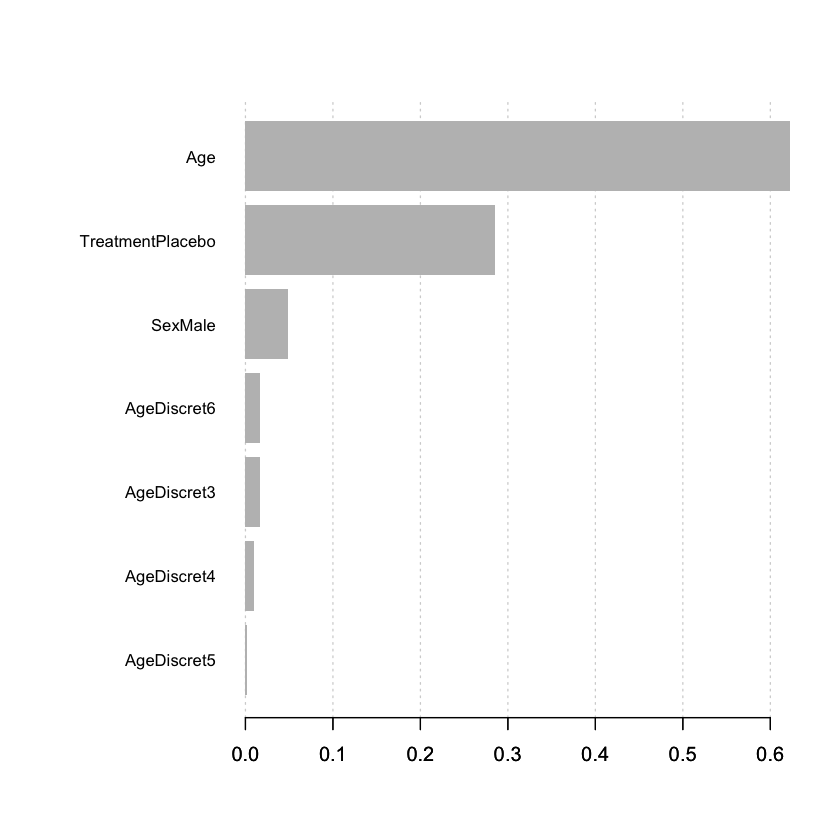

In [12]:
xgb.plot.importance(importance_matrix = importanceRaw)

### 7) Additional Analysis

In [13]:
cAge <- chisq.test(df$Age, output_vector)
print(cAge)


Warning message in chisq.test(df$Age, output_vector):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  df$Age and output_vector
X-squared = 35.475, df = 35, p-value = 0.4458



In [14]:
cAgeDiscret <- chisq.test(df$AgeDiscret, output_vector)
print(cAgeDiscret)


Warning message in chisq.test(df$AgeDiscret, output_vector):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  df$AgeDiscret and output_vector
X-squared = 8.2554, df = 5, p-value = 0.1427



In [15]:
cAgeCat <- chisq.test(df$AgeCat, output_vector)
print(cAgeCat)

Warning message in chisq.test(df$AgeCat, output_vector):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  df$AgeCat and output_vector
X-squared = 2.3571, df = 1, p-value = 0.1247



According to the plot above, the most important features in the dataset is to predict if the treatment will work are :

a) the Age factor

b) having received a placebo or not

c) the sex is third but already included in the not interesting features group

d) we observe our generated features (AgeDiscret)- their contribution is very low.


### Conclusion Remarks

As we notice, in general, destroying information by simplifying it won’t improve our model. Chisquare parameter values demonstrates those aspects after we execute our feature importance from model using XGBoost.

However, in more complex cases, creating a new feature based on existing one which makes link with the outcome more obvious may help the algorithm and improve the model. This may depend on the scale that we are looking at in our dataset and of course flavour of variation between parameters, correlations between features considered and so many other dimensions as well.

The case studied here is not enough complex to show that. We can explore later on more challenging datasets to discover that. However it’s almost always worse when you add some arbitrary rules.

Moreover, we can notice that even if we have added some "not so useful" new features highly correlated with other features, the boosting tree algorithm have been able to choose the best one, which in this case is the "Age" feature.

Linear models may not be that smart in this scenario.